# Homework 4

## Import required libraries

In [123]:
import numpy as np
import matplotlib.pyplot as plt

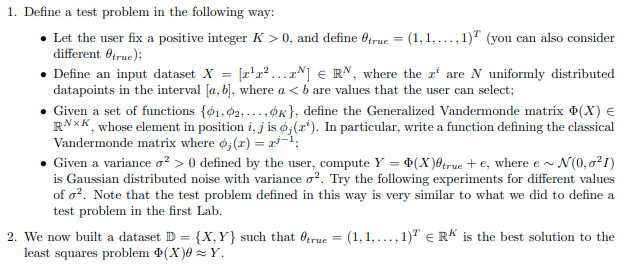

## Defining useful functions

In [145]:
#helping functions
def vander(X, K):
    vand = np.ones((len(X), K))
    for i in range(1,K):
        vand[:,i] = X**i
    return vand

def err_abs(D, K, theta): # 3, second point.
    X, Y = D
    phi = vander(X, K)
    return np.linalg.norm(phi@theta - Y, 2) / len(X)

def err(theta, true_sol):
    true_sol = np.array(true_sol)
    
    t = len(true_sol)
    l = len(theta)
    
    # If the estimated theta is longer, we pad the true solution; if shorter, we pad theta
    if l > t:
        true_sol_padded = np.pad(true_sol, (0, l - t), 'constant', constant_values=(0))
        return np.linalg.norm(theta - true_sol_padded, 2) / np.linalg.norm(true_sol_padded, 2)
    else:
        theta_padded = np.pad(theta, (0, t - l), 'constant', constant_values=(0))
        return np.linalg.norm(theta_padded - true_sol, 2) / np.linalg.norm(true_sol, 2)



def dataset_definition(N, K, training_size_percent=0.7, a=0, b=1, variance=0.1, plot=False):
    X = np.linspace(a, b, N) 
    phi = vander(X, K)
    Y = phi@theta_true
    noise = np.random.normal(0,variance,len(Y))
    Y_noise = Y+noise
    train, test = train_split_data(X, Y_noise, training_size_percent)

    if(plot == True):
        plt.figure(figsize=(3,3))
        plt.plot(X,Y_noise,"ro", markersize=4)
        plt.grid()
        plt.show()

    return train, test


def train_split_data(X, Y, percent_train):
    N = X.shape[0]  # Note that N: number of samples
    Ntrain = int(N * percent_train)
    print(f"Input X shape: {X.shape}, Input Y shape: {Y.shape}, Ntrain: {Ntrain}")

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    print(f"Output Xtrain shape: {Xtrain.shape}, Ytrain shape: {Ytrain.shape}")
    print(f"Output Xtest shape: {Xtest.shape}, Ytest shape: {Ytest.shape}")

    return (Xtrain, Ytrain), (Xtest, Ytest)

# GD function
def GD(D, K, f, grad_f, x0, tolf=1e-5, tolx=1e-5, k_max=1000, alpha=1e-3):
    (X, Y) = D
    x_k = x0
    k = 0
    prev_x = x_k
    
    
    while k < k_max:
        grad_func = grad_f(prev_x, K, X, Y) 

        prev_x = x_k
        x_k = prev_x - alpha * grad_func

        # Store intermediate values
        
        # Check stopping conditions based on tolerance  
        if np.linalg.norm(grad_func, 2) < tolf * np.linalg.norm(grad_func, 2):
            break
        if np.linalg.norm(x_k - prev_x, 2) < tolx:
            break
        k += 1
    
    # Final reporting
    if k == k_max:
        print("Max iterations reached")
    
    return x_k

#SGD function
def SGD(D, K, f, grad_f, w0, batch_size = 12, n_epochs = 5, alpha=1e-5):
    X, Y = D  #Split D into X and Y
    N = X.shape[0]

    n_batch_per_epoch = N//batch_size
    tot_batch = n_batch_per_epoch * n_epochs
    
    w = np.array(w0)
    
    w_history = [w0]  # Save weights at each iteration
    
    # Initialize a vector that saves the gradient of the loss at each iteration
      
    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)
        
        for b in range (n_batch_per_epoch):  
            batch_indices = idx[b * batch_size : (b + 1) * batch_size]

            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]

            w = w_history[-1] - alpha * grad_f(w_history[-1], K, X_batch, Y_batch) 
            w_history.append(w)
            
        

    return w_history[-1]

In [146]:
# defining the MLE and MAP functions and their gradients
def f_MLE(theta, K, X, Y):
    
    phi = vander(X, K)

    predictions = phi @ theta

    # MSE between predictions and target values
    mse = np.linalg.norm(predictions - Y)**2 / 2

    return mse

def grad_f_MLE(theta, K, X, Y):

    phi = vander(X, K)

    gradient = phi.T @ (phi @ theta - Y)

    return gradient

def f_MAP(lamb):
    
    def map_loss(theta, K, X, Y):
        # Compute the Vandermonde matrix for input data X up to degree K
        phi = vander(X, K)

        # Compute the model's predictions for X
        predictions = phi @ theta

        # Calculate the regularized MSE
        regularized_mse = np.linalg.norm(predictions - Y)**2 / 2 + (lamb/2) * np.linalg.norm(theta)**2

        return regularized_mse

    return map_loss

def grad_f_MAP(lamb):

    def map_gradient(theta, K, X, Y):
        # Compute the Vandermonde matrix for input data X up to degree K
        phi = vander(X, K)

        # Compute the gradient with regularization
        gradient = phi.T @ (phi @ theta - Y) + lamb * theta

        return gradient

    return map_gradient


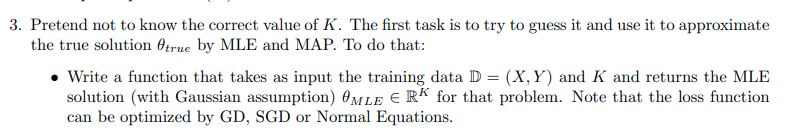

In [147]:
def mle(D, K, kind="normal", var=0.1):
    (X,Y) = D
    phi = vander(X,K)
    theta = np.ones(K)

    if kind == "normal":
        theta_mle = np.linalg.solve(phi.T @ phi , phi.T @ Y) # use cholesky, first matrix is SPD
        return theta_mle
    elif kind == "GD":
        theta_zero = np.zeros((K,))
        theta = GD(D, K, f_MLE, grad_f_MLE, theta_zero)
        return theta
    elif kind == "SGD":
        theta_zero = np.random.normal(1, var, K) # np.zeros(K)
        theta = SGD(D, K, f_MLE, grad_f_MLE, theta_zero)
        return theta
    else: 
        print("Kind not recognised")
        return theta

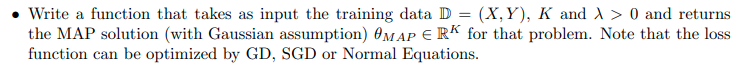

In [148]:
def MAP(D, K, lamb = 0.5,kind="normal", var=0.1):
    (X,Y) = D
    phi = vander(X,K)
    theta_map = np.ones(K)

    if kind == "normal":
        theta_map = np.linalg.solve(phi.T @ phi , phi.T @ Y) # use cholesky, first matrix is SPD
        return theta_map
    elif kind == "GD":
        theta_zero = np.zeros((K,))
        theta_map = GD(D, K, f_MAP(lamb), grad_f_MAP(lamb), theta_zero)
        return theta_map
    elif kind == "SGD":
        theta_zero = np.random.normal(1, var, K) # np.zeros(K)
        theta_map = SGD(D, K, f_MAP(lamb), grad_f_MAP(lamb), theta_zero)
        return theta_map
    else: 
        print("Kind not recognised")
        return theta_map

Input X shape: (200,), Input Y shape: (200,), Ntrain: 140
Output Xtrain shape: (140,), Ytrain shape: (140,)
Output Xtest shape: (60,), Ytest shape: (60,)


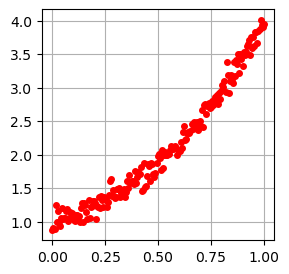

In [149]:
#Define variables - Part 1
N = 200
K = 4 # degree of the polinomial
theta_true = np.ones((K,)) # true solution
a, b = 0, 1
variance = 0.1
training_size_percent = 0.7

train, test = dataset_definition(N, K, training_size_percent = training_size_percent, 
                                                  a = a, b = b, variance = variance, plot=True)

Xtrain, Ytrain = train
Xtest, Ytest = test


In [150]:
def plot_approximation(D, K, theta, a=0, b=1, points=1000, all=False, T=(), lam=[]):
    Xtrain, Ytrain = D
    # Plot the training data
    plt.plot(Xtrain, Ytrain, "ro", markersize=3, label="Dataset")

    # Generate points for the approximation line
    X_aprox = np.linspace(a, b, points)
    Y_aprox = vander(X_aprox, K) @ theta

    # Plot the approximation
    plt.plot(X_aprox, Y_aprox, label="Approximation")

    # Add grid, legend, and show the plot
    plt.grid()
    plt.legend()
    plt.show()

## MLE - Normal equations

Absolute error on training set:  0.018439439211440187
Absolute error on test set:  0.02643681789486439
Err(theta):  1.1948494090800037


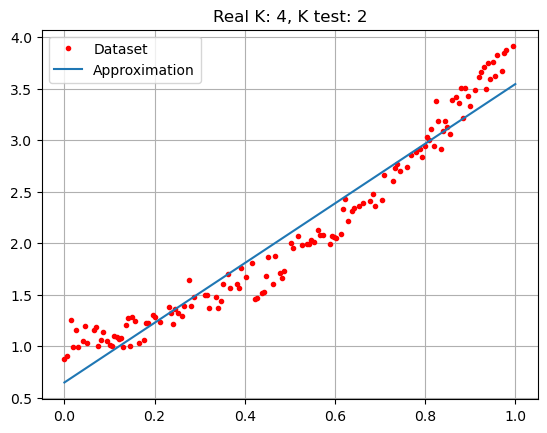

Absolute error on training set:  0.008643015969573752
Absolute error on test set:  0.011496109458840827
Err(theta):  0.262146789615664


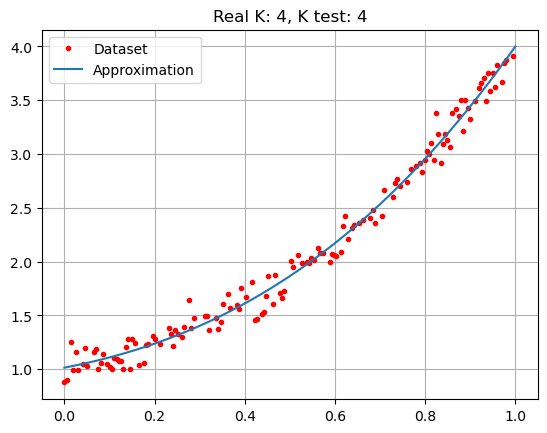

Absolute error on training set:  0.008182067026548593
Absolute error on test set:  0.04230298406757805
Err(theta):  2169291.4427104043


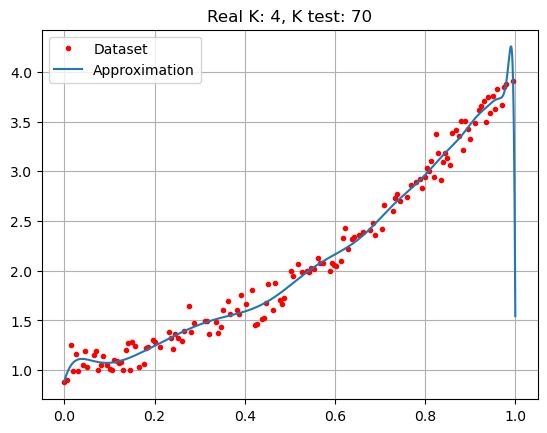

In [172]:
K_test = 2

theta_mle = mle(train, K_test, kind="normal")
print("Absolute error on training set: ",err_abs(train,K_test,theta_mle))
print("Absolute error on test set: ",err_abs(test,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(train, K_test, theta_mle)


K_test = 4

theta_mle = mle(train, K_test, kind="normal")
print("Absolute error on training set: ",err_abs(train,K_test,theta_mle))
print("Absolute error on test set: ",err_abs(test,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(train, K_test, theta_mle)

K_test = 70

theta_mle = mle(train, K_test, kind="normal")
print("Absolute error on training set: ",err_abs(train,K_test,theta_mle))
print("Absolute error on test set: ",err_abs(test,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(train, K_test, theta_mle)

The best tradeoff is given by K = 4


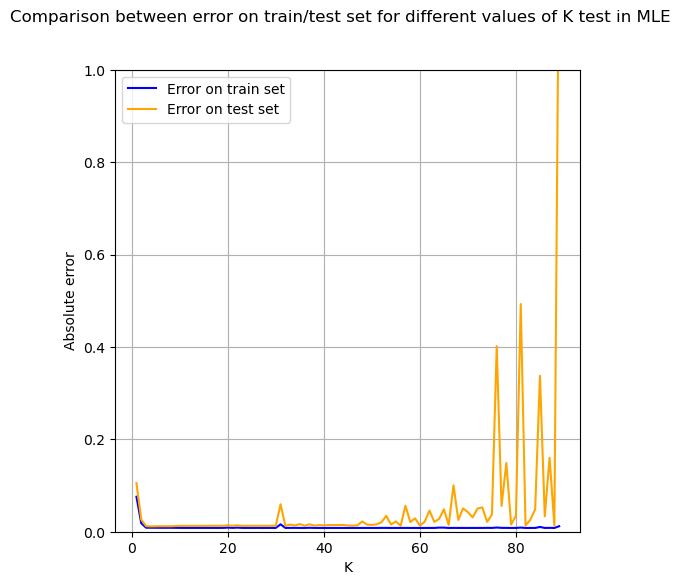

In [184]:
err_train = []
err_test = []
k_max = 90
for k in range(1, k_max):
    theta_mle = mle(train, k, kind="normal")
    err_train.append(err_abs(train,k,theta_mle))
    err_test.append(err_abs(test,k,theta_mle))

dif = abs(np.array(err_train) - np.array(err_test))
index = np.argmin(dif)+1
print("The best tradeoff is given by K =",index)

x_plot = np.arange(1,k_max)
plt.figure(figsize=(6,6))
plt.suptitle("Comparison between error on train/test set for different values of K test in MLE")
plt.plot(x_plot, err_train, color="blue")
plt.plot(x_plot, err_test, color="orange")
plt.legend(["Error on train set","Error on test set"])
plt.xlabel("K")
plt.ylabel("Absolute error")
plt.ylim(0,1)
plt.grid()
plt.show()

## MLE - GD 

Max iterations reached
Absolute error during training:  0.008672575654280604
Absolute error during testing:  0.011280671574462518
Err  0.025187886207437636


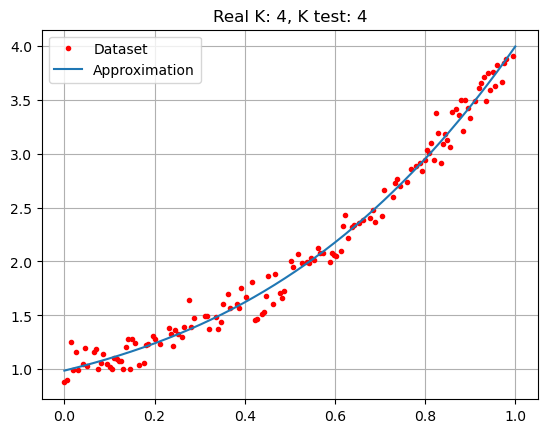

Max iterations reached
Absolute error during training:  0.00859235406661614
Absolute error during testing:  0.012060854115309761
Err  0.3571970171729768


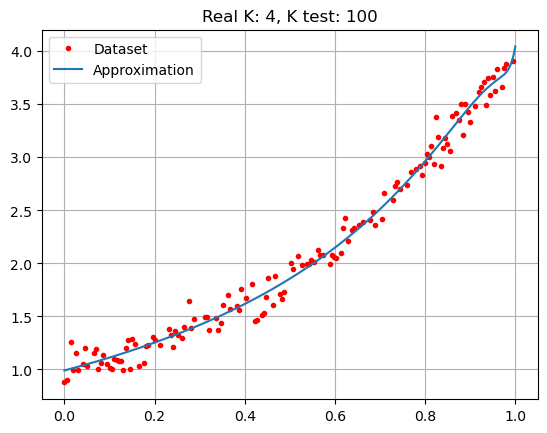

In [185]:
K_test = 4

theta_mle = mle(train, K_test, kind="GD")
print("Absolute error during training: ",err_abs(train,K_test,theta_mle))
print("Absolute error during testing: ",err_abs(test,K_test,theta_mle))
print("Err ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))

plot_approximation(train, K_test, theta_mle)

K_test = 100

theta_mle = mle(train, K_test, kind="GD")
print("Absolute error during training: ",err_abs(train,K_test,theta_mle))
print("Absolute error during testing: ",err_abs(test,K_test,theta_mle))
print("Err ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(train, K_test, theta_mle)

## MLE - SGD

Absolute error during training:  0.7533450696874741
Absolute error during testing:  2.086962601303626
Err  4.905797206595252


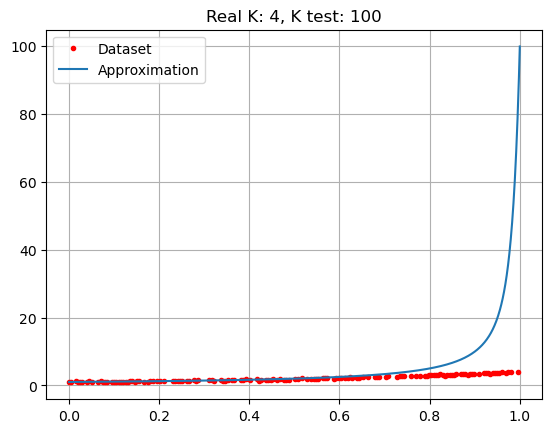

Absolute error during training:  0.01365108546761633
Absolute error during testing:  0.01882557769685876
Err  0.07709920061791921


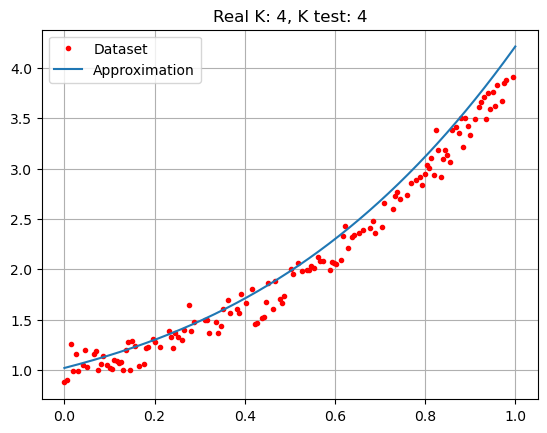

In [186]:
K_test = 100

theta_mle = mle(train, K_test, kind="SGD")
print("Absolute error during training: ",err_abs(train,K_test,theta_mle))
print("Absolute error during testing: ",err_abs(test,K_test,theta_mle))
print("Err ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(train, K_test, theta_mle)


K_test = 4

theta_mle = mle(train, K_test, kind="SGD")
print("Absolute error during training: ",err_abs(train,K_test,theta_mle))
print("Absolute error during testing: ",err_abs(test,K_test,theta_mle))
print("Err ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(train, K_test, theta_mle)


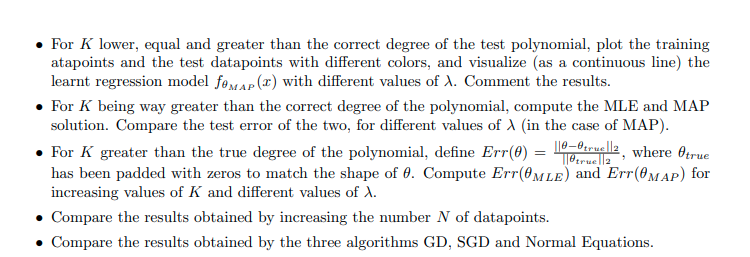

In [203]:
K_values = [K - 1, K, K + 1,40]  # K is the true degree from your setup
lambda_values = [0.01, 0.1, 1]

## MAP - Normal Equations

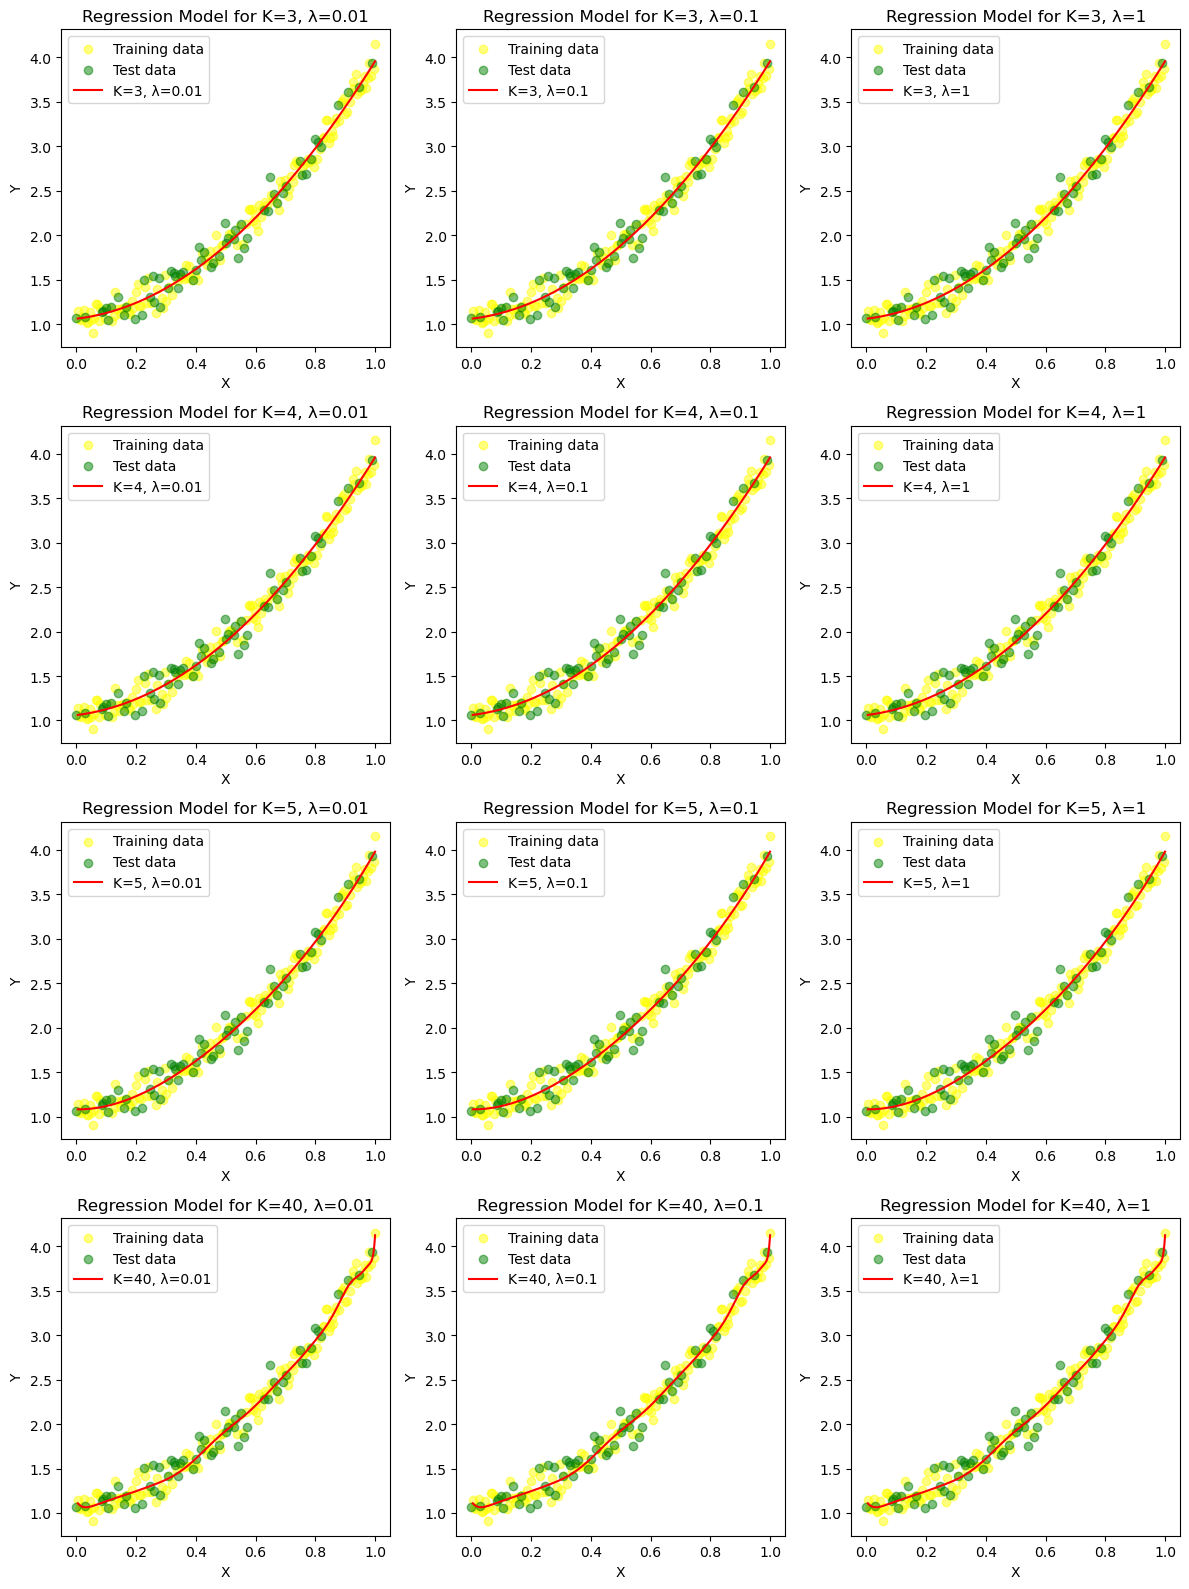

In [204]:
n_rows = len(K_values)
n_cols = len(lambda_values)

plt.figure(figsize=(n_cols * 4, n_rows * 4))

for i, K_test in enumerate(K_values):
    for j, lam in enumerate(lambda_values):
        theta_map = MAP(train, K_test, lam, kind="normal")
        
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        plt.scatter(Xtrain, Ytrain, color='yellow', label='Training data', alpha=0.5)
        plt.scatter(Xtest, Ytest, color='green', label='Test data', alpha=0.5)
        
        X_aprox = np.linspace(min(Xtrain), max(Xtrain), 1000)
        Y_aprox = vander(X_aprox, K_test) @ theta_map

        # Plot the regression line
        plt.plot(X_aprox, Y_aprox, color='red', label=f"K={K_test}, λ={lam}")
        
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f"Regression Model for K={K_test}, λ={lam}")
        plt.legend()

plt.tight_layout()  
plt.show()

## MAP - GD

Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached


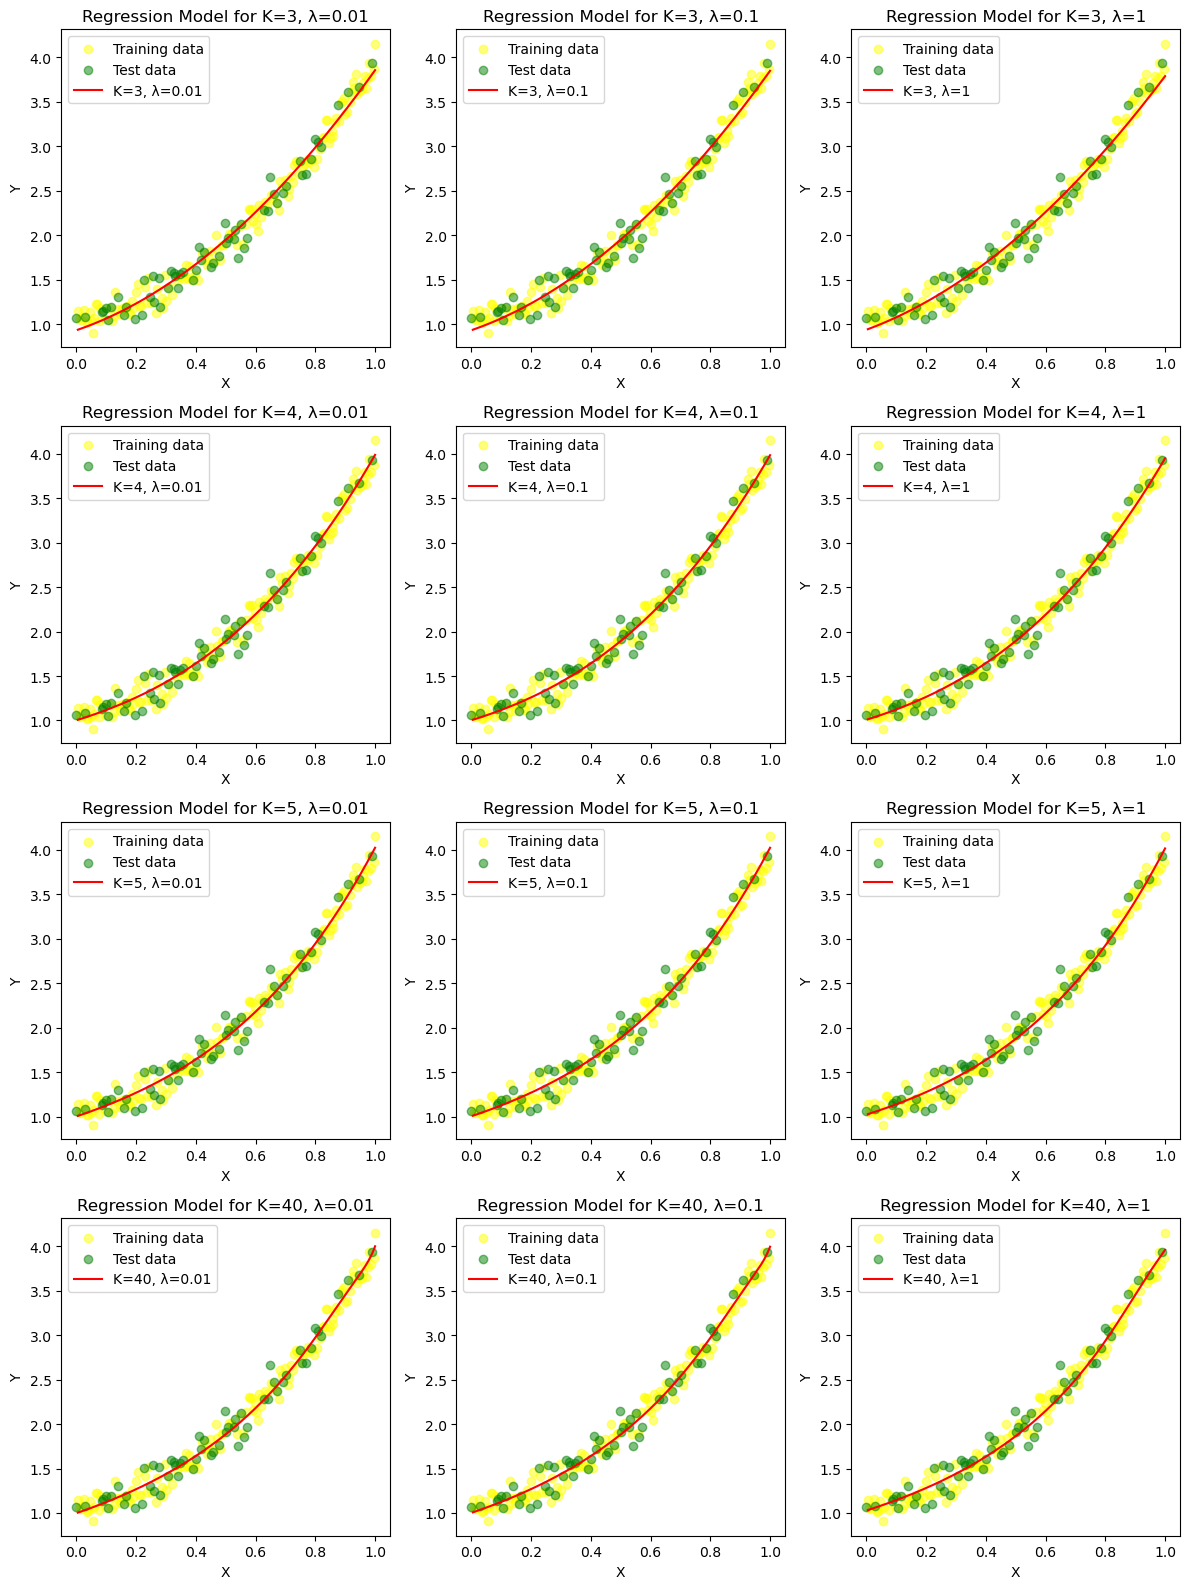

In [205]:
n_rows = len(K_values)
n_cols = len(lambda_values)

plt.figure(figsize=(n_cols * 4, n_rows * 4))

for i, K_test in enumerate(K_values):
    for j, lam in enumerate(lambda_values):
        theta_map = MAP(train, K_test, lam, kind="GD")
        
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        plt.scatter(Xtrain, Ytrain, color='yellow', label='Training data', alpha=0.5)
        plt.scatter(Xtest, Ytest, color='green', label='Test data', alpha=0.5)
        
        X_aprox = np.linspace(min(Xtrain), max(Xtrain), 1000)
        Y_aprox = vander(X_aprox, K_test) @ theta_map

        # Plot the regression line
        plt.plot(X_aprox, Y_aprox, color='red', label=f"K={K_test}, λ={lam}")
        
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f"Regression Model for K={K_test}, λ={lam}")
        plt.legend()

plt.tight_layout()  
plt.show()

## MAP - SGD

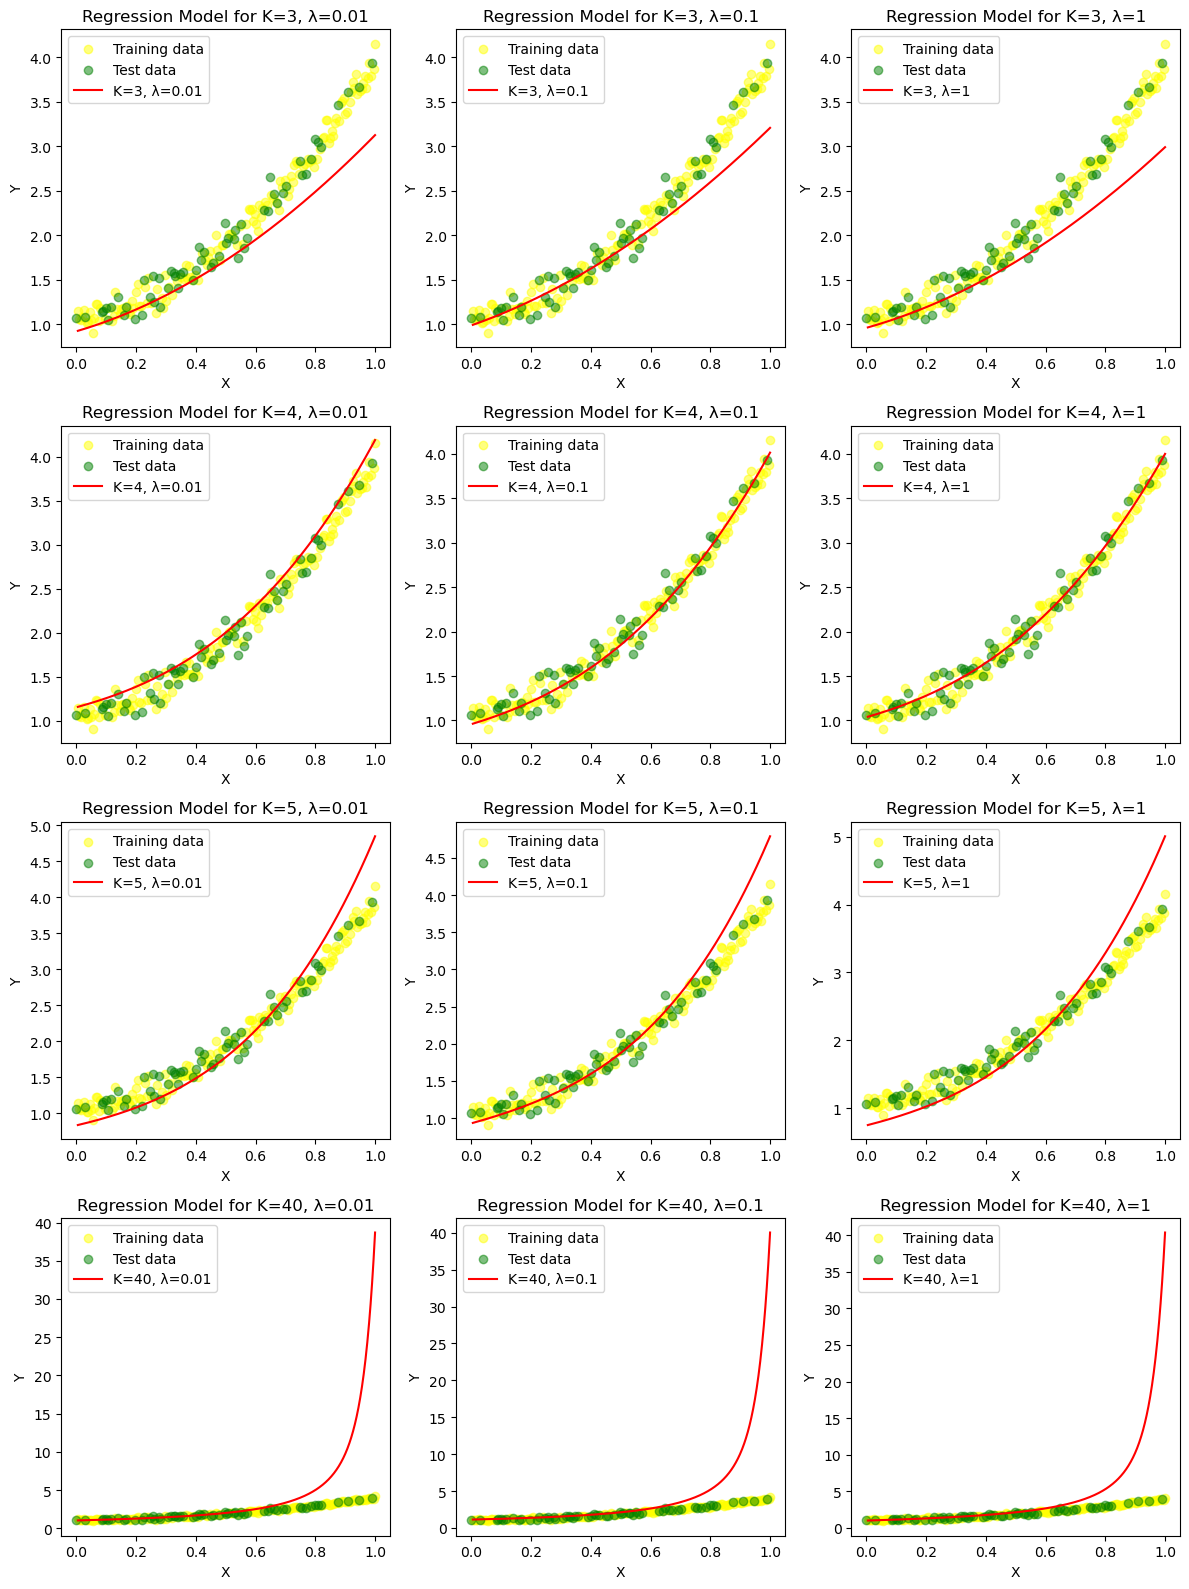

In [206]:
n_rows = len(K_values)
n_cols = len(lambda_values)

plt.figure(figsize=(n_cols * 4, n_rows * 4))

for i, K_test in enumerate(K_values):
    for j, lam in enumerate(lambda_values):
        theta_map = MAP(train, K_test, lam, kind="SGD")
        
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        plt.scatter(Xtrain, Ytrain, color='yellow', label='Training data', alpha=0.5)
        plt.scatter(Xtest, Ytest, color='green', label='Test data', alpha=0.5)
        
        X_aprox = np.linspace(min(Xtrain), max(Xtrain), 1000)
        Y_aprox = vander(X_aprox, K_test) @ theta_map

        # Plot the regression line
        plt.plot(X_aprox, Y_aprox, color='red', label=f"K={K_test}, λ={lam}")
        
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f"Regression Model for K={K_test}, λ={lam}")
        plt.legend()

plt.tight_layout()  
plt.show()